In [2]:
DATASET_DIR="/run/media/mkls/Media/Загрузки"

In [3]:
import datetime as dt
from csv import DictReader
from typing import List

class CsvDataset:
    def __init__(self, fname: str):
        self.fname = fname
    
    def __call__(self, batch_size: int = 0, time_col: str = "date",
                 time_window: dt.timedelta = None, columns: List[str] = None,
                 time_format: str = None, drop_last: bool = True, text_column: str = "text",
                 max_size: int = 0):
        batch = []
        start_time = None
        
        assert (time_window is not None and time_col is not None and time_format is not None) or batch_size != 0
        
        with open(self.fname, "r") as fd:
            reader = DictReader(fd)
            for line in reader:
                cur_time = dt.datetime.strptime(line[time_col], time_format).date()

                if start_time is None:
                    batch = []
                    start_time = cur_time

                if (time_window is not None and cur_time > start_time + time_window) or\
                   (batch_size != 0 and len(batch) == batch_size) or\
                   (max_size > 0 and len(batch) == max_size):
                    start_time = None
                    yield batch
                else:
                    if len(batch) > 0 and line[text_column] != batch[-1][text_column] or len(batch) == 0:
                        batch.append({key: line[key] for key in columns})
        if len(batch) > 0 and not drop_last:
            yield batch
        raise StopIteration

In [4]:
from transformers import AutoTokenizer, T5ForConditionalGeneration


# model_name = "IlyaGusev/rut5_base_headline_gen_telegram"


def summarize(text: str, model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    input_ids = tokenizer(
    [text],
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        max_length=200,
        return_tensors="pt"
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        no_repeat_ngram_size=3,
        max_length=128,
        num_beams=20,
        early_stopping=True
    )[0]

    summary = tokenizer.decode(output_ids, skip_special_tokens=True)
    return summary

2022-04-07 20:15:04.156402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 20:15:04.156427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# dataset = CsvDataset(DATASET_DIR + '/lenta-ru-news.csv')
dataset = CsvDataset(DATASET_DIR + '/aggr_articles_consolidated_2010-2021.csv')

In [6]:
from preproc import Preprocessor, LangEnum

In [7]:
preprocessor = Preprocessor(language=LangEnum.RU, tokenize_ents=False)

In [8]:
def crutch_for_top2vec(doc):
    return doc.split()

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
ds_generator = dataset(time_window=dt.timedelta(days=2), time_col="date",
                       columns=['title', 'text', 'date'], time_format="%Y-%m-%d %H:%M:%S",
                       max_size=5000)

In [ ]:
import csv
from models import Top2VecW
from tqdm.notebook import tqdm

import logging
logging.disable(logging.WARNING);
import gc

# models = []
output_dir = "/run/media/mkls/Media/ml/coursework2/events-topics/"
# model_name = "IlyaGusev/rut5_base_sum_gazeta"

with open(output_dir + 'result.csv', 'a') as of:
    writer = csv.writer(of)
    # writer.writerow(['batch_id', 'refdoc_id', 'text', 'date'])
    
    for i, batch in tqdm(enumerate(ds_generator)):
        gc.collect()
    
        # event_docs = []
        # event_ids = []
        # event_docs.append([])
        # event_ids.append([])

        frame = list(map(lambda x: x['title'] + ' ' + x['text'], batch))
        doc_iter, _ = preprocessor.preprocess_texts(frame)
        texts = list(map(str, doc_iter))

        try:
            m = Top2VecW(documents=texts,
                         # embedding_model='doc2vec',
                         embedding_model='universal-sentence-encoder-multilingual',
                         # embedding_model='paraphrase-multilingual-MiniLM-L12-v2',
                         workers=12,
                         tokenizer=crutch_for_top2vec)

            for j in range(m.__model__.get_num_topics()):
                docs, scores, ids = m.__model__.search_documents_by_topic(topic_num=j, num_docs=1)
                for doc, score, doc_id in zip(docs, scores, ids):
                    # print(frame)
                    writer.writerow([f"{i}", f"{doc_id}", frame[doc_id], batch[doc_id]['date']])
                    # event_docs.append(doc)
                    # event_ids.append(doc_id)
            # models.append(top2vec)
        except Exception as e:
            # print(e)
            # print('No topics found (top2vec failed) :(')
            continue

0it [00:00, ?it/s]

2022-04-09 02:03:52.538897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-09 02:03:52.538936: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-09 02:03:52.538990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archlinux): /proc/driver/nvidia/version does not exist
2022-04-09 02:03:52.540683: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Coursework 2 code below

In [5]:
time_frames = []

for i, batch in enumerate(dataset(batch_size=220, time_col="date", columns=['title', 'text', 'date'])):
    if i > 7:
        time_frames.append(batch)
    if i > 17:
        break

In [8]:
frames = [list(map(lambda x: x['title'] + '. ' + x['text'], f)) for f in time_frames]

In [9]:
preprocessor = Preprocessor(language=LangEnum.RU, tokenize_ents=False)

preprocessed = []

for frame in frames:
    doc_iter, dictionary = preprocessor.preprocess_texts(frame)
    preprocessed.append(list(map(str, doc_iter)))

In [66]:
frames[0]

['Крупнейшая в\xa0мире телефонная компания выходит из\xa0бизнеса. Крупнейшая в мире японская компания телефонной связи Nippon Telegraph&Telephone Corp. намерена к марту 2003 года сократить 21 тысяч рабочих мест на двух своих предприятиях в Японии - NTT East Corp. и NTT West Corp., что составляет 16 процентов от числа всех работающих. За это же время будут также сокращены и капитальные инвестиции более чем на 8,5 миллиарда долларов. На два года будут отменены вакансии для выпускников ВУЗов, не имеющих опыта работы. Данный шаг бывшая японская правительственная монополия в телекоммуникационном бизнесе предпринимает с целью повысить свою конкурентоспособность по отношения к таким компаниям, как DDI Corp., Japan Telecom Co. и KDD Corp., которые хоть и меньше по размерам, но очень активно продвигаются на внутренний рынок телекоммуникаций Японии, сообщает агентство АК&М со ссылкой на японские СМИ. С другой стороны, президент компании Юнихиро Миязу заявил, что программа сокращения рабочих мест

In [65]:
preprocessed[0]

['крупный мир телефонный компания выходить бизнес крупный мир японский компания телефонный связь nippon_telegraph&telephone_corp март год сократить тысяча рабочий место два предприятие япония_ntt corp ntt_west_corp процент число работать время также сократить капитальный инвестиция более миллиард доллар год отменить вакансия выпускник вуз опыт работа данный шаг бывший японский правительственный монополия телекоммуникационный бизнес предпринимать цель повысить конкурентоспособность отношение компания kdd_corp меньше размер очень активно продвигаться внутренний рынок телекоммуникация япония агентство ак&м ссылка японский сми сторона президент компания юнихиро_миязу программа сокращение рабочий место уменьшение капитальный вложение являться часть стратегия переход компания телефонный бизнес область информационный технология резкий сокращение прибыль компания объясняться переход значительный число клиент мобильный связь указывать информационный служба cnn ссылка агентство ',
 'ельцин стамб

In [10]:
from models import Top2VecW
from tqdm import tqdm

# models = []
event_docs = []
event_ids = []

for i, texts in tqdm(enumerate(preprocessed)):
    event_docs.append([])
    event_ids.append([])
    
    try:
        m = Top2VecW(documents=texts,
                     # embedding_model='doc2vec',
                     embedding_model='universal-sentence-encoder-multilingual',
                     workers=12,
                     tokenizer=crutch_for_top2vec)
        
        for j in range(m.__model__.get_num_topics()):
            docs, scores, ids = m.__model__.search_documents_by_topic(topic_num=j, num_docs=1)
            for doc, score, doc_id in zip(docs, scores, ids):
                event_docs[i].append(doc)
                event_ids[i].append(doc_id)
        # models.append(top2vec)
    except:
        print('No topics found (top2vec failed) :(')
        continue

0it [00:00, ?it/s]2022-01-13 07:34:09,929 - top2vec - INFO - Pre-processing documents for training
/home/mkls/.local/share/miniconda3/envs/event-detection-7/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-13 07:34:09,954 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
2022-01-13 07:34:10.088376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-13 07:34:10.088404: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-13 07:34:10.088425: I tensorflow/stream_executor/cuda/cuda_diagn

INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2022-01-13 07:34:50,351 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-13 07:34:52,730 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-13 07:34:54,389 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-01-13 07:34:54,395 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
7it [00:44,  6.04s/it]2022-01-13 07:34:54,459 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/home/mkls/.local/share/miniconda3/envs/event-detection-7/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out inste

In [35]:
from tqdm import tqdm

dates = []
summaries = []

model_name = "IlyaGusev/rut5_base_sum_gazeta"

for i, ids in tqdm(enumerate(event_ids)):
    for doc_id in ids:
        dates.append(time_frames[i][doc_id]['date'])
        summaries.append(summarize(frames[i][doc_id], model_name))
        

dates = list(map(lambda x: datetime.strptime(x, "%Y/%m/%d"), dates))

11it [14:53, 81.20s/it]


In [34]:
time_frames[10][146]

{'title': 'В Хабаровске похоронили погибших при взрыве газа',
 'text': 'В пятницу в Хабаровске родственники, друзья, общественность и представители местных властей провожали в последний путь погибших при взрыве газа в доме номер 136 по Артемовской улице. Как сообщает РИА "Новости", все расходы по организации похорон взяли на себя администрация края, мэрия и другие местные организации. В городе объявлен траур, отменены все развлекательные мероприятия. В субботу во всех храмах Русской Православной Церкви будет отслужена панихида по погибшим. Некоторые семьи, квартиры которых были разрушены, уже получили ордера на новое жилье. Остальным пострадавшим администрация края оказывает поддержку: организованы пункты питания, сбор одежды, других вещей. На месте трагедии на Артемовской улице по-прежнему работают спасатели. До сих пор не найдена одна из жительниц разрушенного пятого подъезда - пенсионерка Тарасова. Оперативно-следственная группа сотрудников прокуратуры, УВД и ФСБ ведет расследование

In [24]:
summaries[3]

'Ирак остановил экспорт нефти. Ирак подверг критике резолюцию Совета безопасности ООН о продлении программы «Нефть в обмен на продовольствие» на две недели. Министр иностранных дел Ирака Мохаммед Саид эль-Саххаф заявил: «Эта резолюция не имеет никакого смысла с практической точки зрения».'

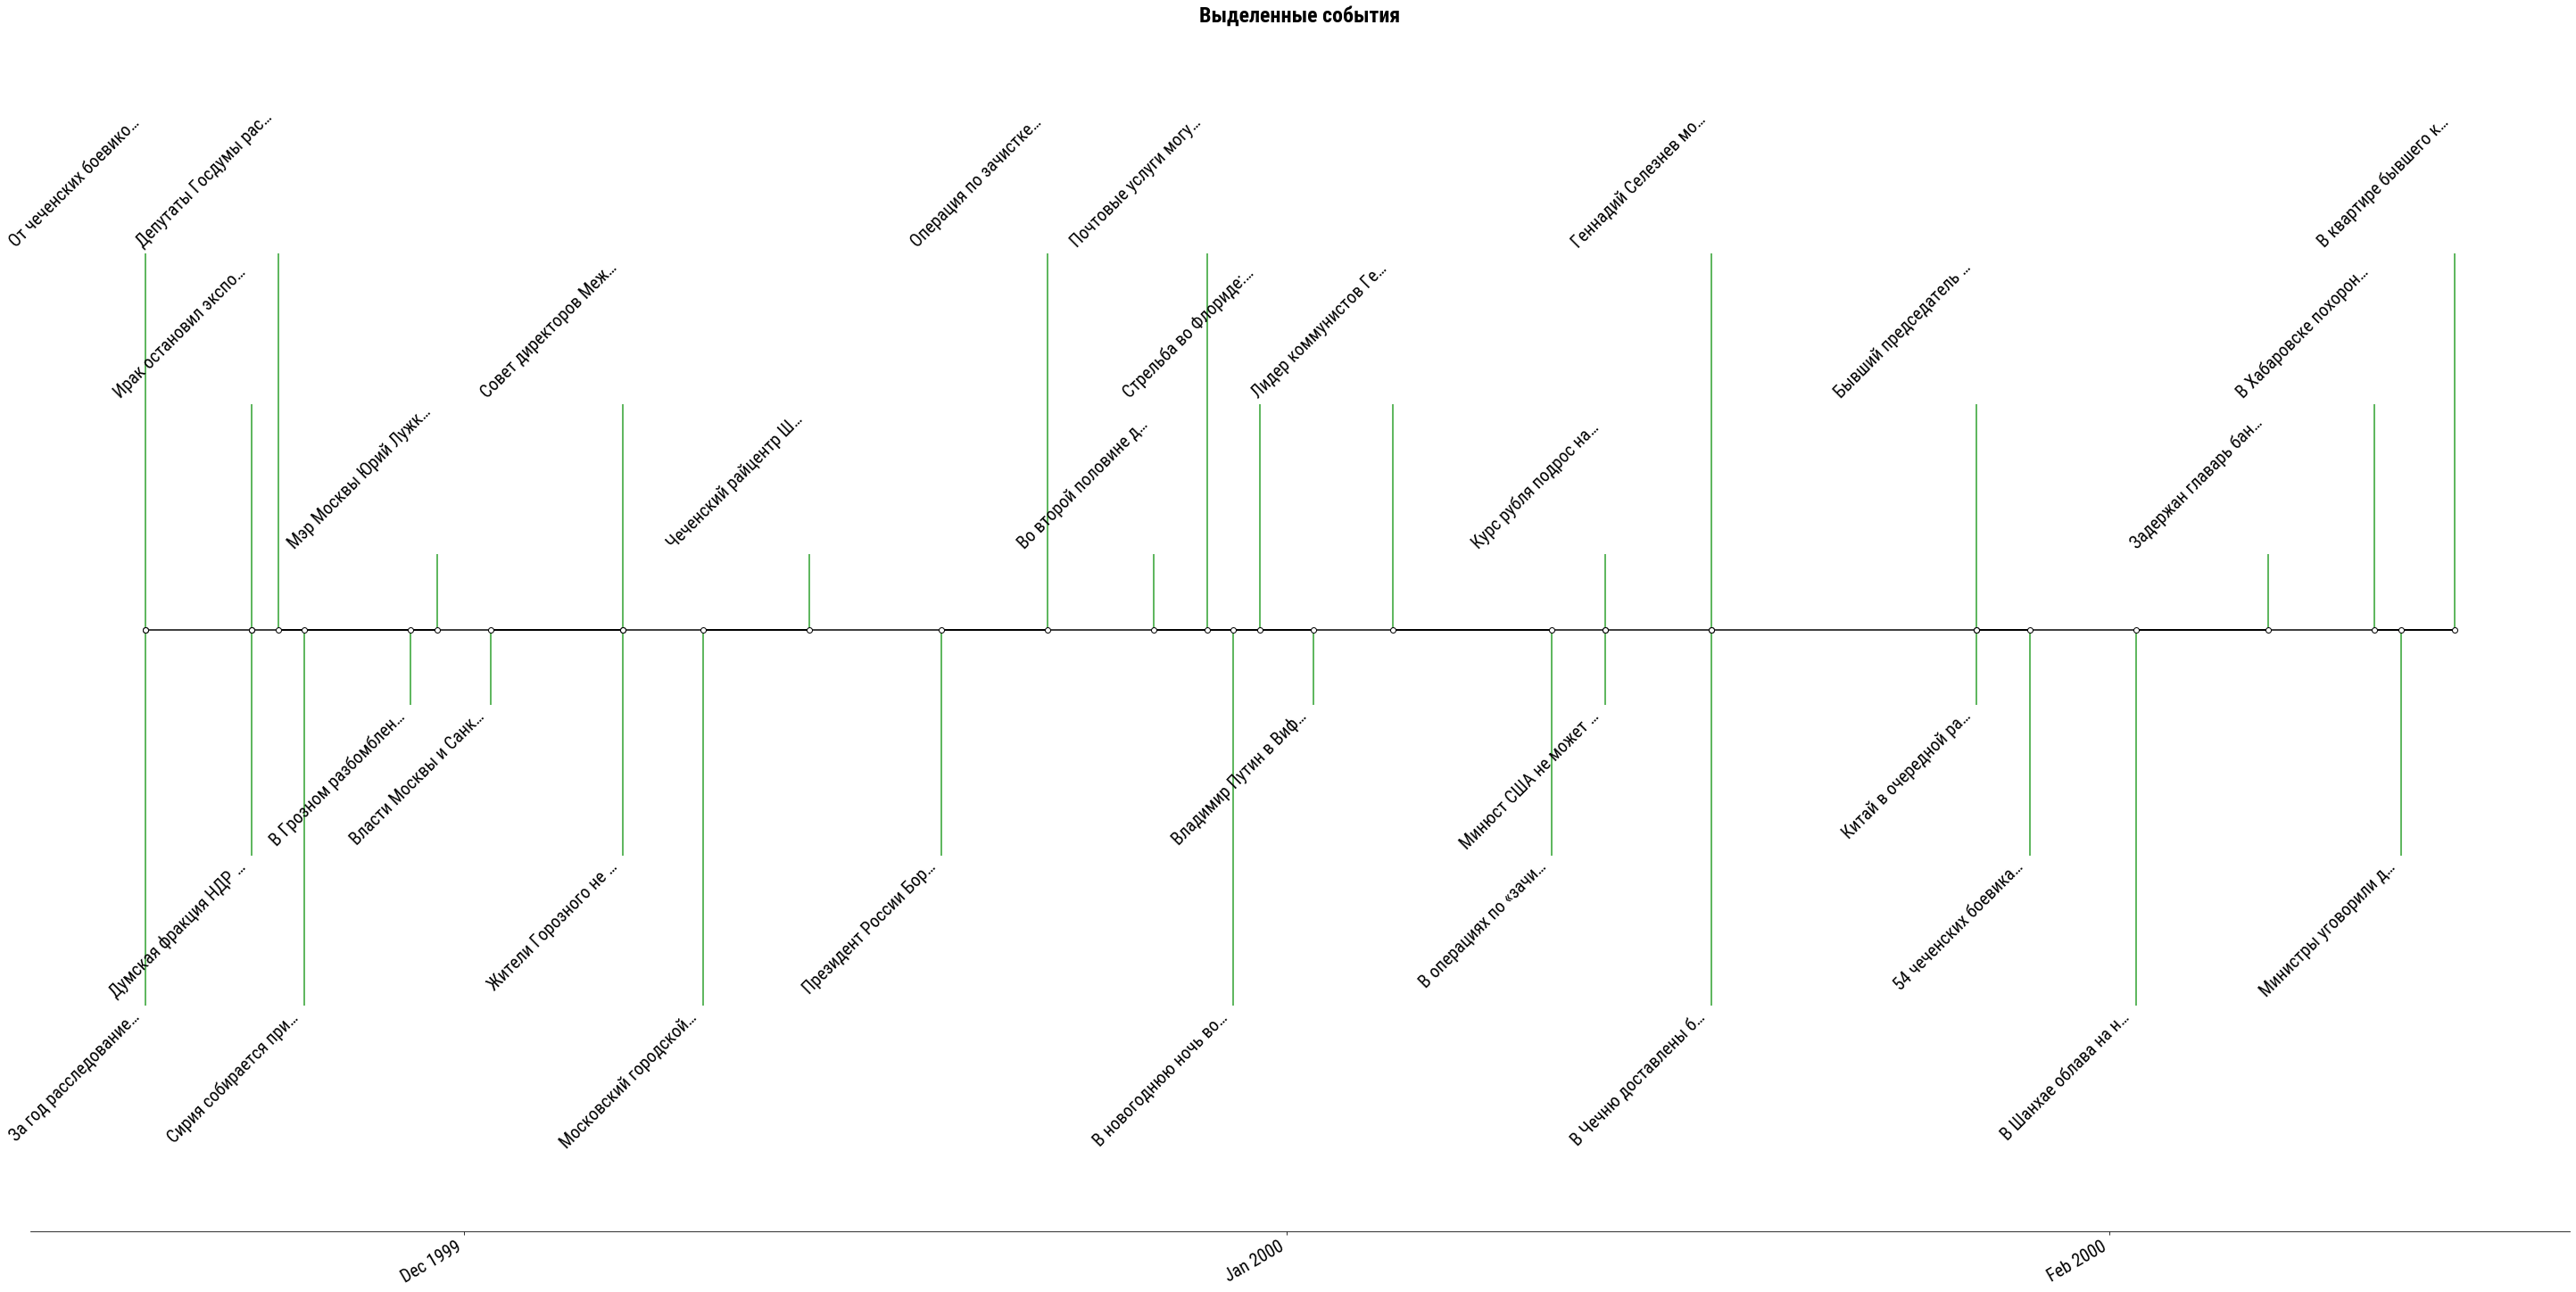

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

font = {'family' : 'Roboto Condensed',
        'weight' : 'regular',
        'size'   : 20}

plt.rc('font', **font)


levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

fig, ax = plt.subplots(figsize=(40, 20), constrained_layout=True)
ax.set_title("Выделенные события", fontweight="bold")

ax.vlines(dates, 0, levels, color="tab:green")
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")

for d, l, r in zip(dates, levels, map(lambda s: s[:20]+"…", summaries)):
    ax.annotate(r, xy=(d, l), rotation=45,
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.margins(y=0.3)
plt.show()

In [45]:
print(summary)

Операция по зачистке Грозного началась несколько дней назад, но лобового штурма города не будет. В Грозном находятся от двух до двух с половиной тысяч боевиков. На вооружении бандитов есть несколько танков, а также восемь единиц бронетехники, пять-шесть зенитных установок, несколько систем залпового огня «Град».


In [24]:
from transformers import AutoTokenizer, EncoderDecoderModel

model_name = "IlyaGusev/rubert_telegram_headlines"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False, do_basic_tokenize=False, strip_accents=False)
model = EncoderDecoderModel.from_pretrained(model_name)


input_ids = tokenizer(
    [frames[0][149]],
    add_special_tokens=True,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    max_length=128,
    no_repeat_ngram_size=5,
    num_beams=5,
    top_p=0.95
)[0]

headline = tokenizer.decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print(headline)

Операция " зачистка" Грозного началась не раньше, чем планировалось
